<a href="https://colab.research.google.com/github/archiechang/study/blob/master/analysis/weather_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **温暖化有無分析（日本）**


---


## 前提
- 日本の温暖化有無≒東京都温暖化有無と仮定
- [気象庁](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)東京都過去30年(1993/1～2022/12)の気象データを観測



---



## 解析用モデル：自己回帰（AR）モデル
時系列データのモデル化に使われる方法の一つであり、過去の観測値を使って未来の値を予測することを目的としています。ARモデルの基本的な式は次のように表されます：

$$ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + \varepsilon_t $$

- $X_t$  は時点 $( t )$ での時系列データの値。
- $( c )$ は定数項。
- $( \phi_1, \phi_2, \ldots, \phi_p)$ はモデルのパラメータ。
- $( \varepsilon_t )$ は時点 $( t )$ での誤差項。これは通常、平均0で一定の分散を持つホワイトノイズと仮定されます。

この式は、時点 $( t )$ での時系列データの値 $( X_t )$ が、その過去の値 $( X_{t-1}, X_{t-2}, \ldots, X_{t-p} )$ の線形結合であることを表しています。そして、各過去の値に対してはパラメータ $( \phi_1, \phi_2, \ldots, \phi_p )$ が乗じられています。


---
## 分析データ項目
- 平均気温(℃)
- 最高気温(℃)
- 最低気温(℃)
- 降水量の合計(mm)
- 日降水量の最大(mm)
- 雪日数(日)


---

## 分析サマリ
1. トレンド分析結果を見たところ、温暖化が進行していると考えられる
2. 平均気温、合計降水量、雪日数の2030,2050年を予測
 - 平均気温
    - 予測と実績は概ねあっているが、2022/1-3,2022/6-9のがずれている。
    - 2030年は2022年と比べて全体的+1.0度となり、春・夏の平均温度下がり、秋・冬の平均温度は上がっている
    - 2050年は2022年と比べて全体的+2.0度となり、夏・秋の平均温度下がり、冬・春の平均温度は上がっている
 - 合計降水量、雪日数：予測結果精度が低く、降水量の合計を予測するには曇など他のパラメータも入れないといけない


---

## 高度化検討
### 分析
1. 対象地域の拡大：東京だけでなく、他の都市の気象データを観測。特に都市開発など外部要因影響が少ない都市が良い
2. 長期的なデータの確保：平均気温に関して直近8年分しかなかったが、別のルートで入手するか、線形モデルなどで予測値で補完することで、学習データを増やす
3. パラメータの増加：他に気温に関連するデータ、風速、湿度、日射量、雲量などの追加

### 予測モデル
1. 分析検討事項1~3
2. 多変量解析モデルの使用：今回は単変量ARモデルを使いましたが、気温・降水量・風速など複数の変量を同時に解析。例えば、MARIMAで複数時系列のデータを同時にモデル化
3. 最適化と検証：モデルのハイパーパラメータの選択や、交差検証といったモデルの検証手法でモデルの最適化を実施。



## **SETUP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


パラメータ定義

In [ ]:
INPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/data/weather_data.csv"
TRAIN_SIZE=0.8
PREDICT_START=60*12 #2033~2053 60年間

## **ファイル読み込み**

In [ ]:
import pandas as pd

raw_data = pd.read_csv(INPUT_FILE, skiprows=3, encoding="shift-jis")
raw_data.head()

,Unnamed: 0,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),日降水量の最大(mm),雪日数(日)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993年1月,///,12.9,1.2,115.0,32.5,5.0
2,1993年2月,///,21.9,0.7,57.0,22.0,1.0
3,1993年3月,///,18.3,1.5,60.5,15.5,2.0
4,1993年4月,///,26.9,4.8,58.0,21.5,0.0


## **データクレンジング**

In [ ]:
df=raw_data.copy()

# 不要な行を削除
df.drop(index=0, inplace=True)


# 列名修正
cols=df.columns
df.rename(columns={cols[0]: 'date'}, inplace=True)

# 日付型変換
df['date']=df['date'].str.replace(' ','')
df['date']= pd.to_datetime(df['date'], format='%Y年%m月')
df.set_index('date', inplace=True)

# 各実績値を数値に変換し、欠損値を確認
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1993-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   平均気温(℃)      97 non-null     float64
 1   最高気温(℃)      360 non-null    float64
 2   最低気温(℃)      359 non-null    float64
 3   降水量の合計(mm)   359 non-null    float64
 4   日降水量の最大(mm)  359 non-null    float64
 5   雪日数(日)       360 non-null    float64
dtypes: float64(6)
memory usage: 19.7 KB



補完内容
1.   最低気温(℃),降水量の合計(mm), 日降水量の最大(mm)：前年実績で補完
2.   平均気温：最高、最低気温の平均値で補完


In [ ]:
import numpy as np

def previous_year_value_completion(df, col):
    # 欠損値を検出
    missing_dates = df[df[col].isnull()].index

    # 前年同月の値で補完
    for missing_date in missing_dates:
        previous_year_date = missing_date.replace(year=missing_date.year - 1)
        if previous_year_date in df.index:
            df.loc[missing_date, col] = df.loc[previous_year_date, col]
    return df

# 最低気温(℃),降水量の合計(mm), 日降水量の最大(mm)：前年実績で補完
completion_tar = ["最低気温(℃)",
                  "降水量の合計(mm)",
                  "日降水量の最大(mm)"]
for tar in completion_tar:
    df = previous_year_value_completion(df, tar)

# 平均気温：最高、最低気温の平均値で補完
average_temp = (df["最高気温(℃)"] + df["最低気温(℃)"]) / 2
df["平均気温(℃)"] = np.where(df["平均気温(℃)"].isnull(), average_temp, df["平均気温(℃)"])

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 1993-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   平均気温(℃)      360 non-null    float64
 1   最高気温(℃)      360 non-null    float64
 2   最低気温(℃)      360 non-null    float64
 3   降水量の合計(mm)   360 non-null    float64
 4   日降水量の最大(mm)  360 non-null    float64
 5   雪日数(日)       360 non-null    float64
dtypes: float64(6)
memory usage: 27.8 KB
None
            平均気温(℃)  最高気温(℃)  最低気温(℃)  降水量の合計(mm)  日降水量の最大(mm)  雪日数(日)
date                                                                  
1993-01-01     7.05     12.9      1.2       115.0         32.5     5.0
1993-02-01    11.30     21.9      0.7        57.0         22.0     1.0
1993-03-01     9.90     18.3      1.5        60.5         15.5     2.0
1993-04-01    15.85     26.9      4.8        58.0         21.5     0.0
1993-05-01    19.50     30.7      8.3        65.5         21.0     0.

## **温暖化有無分析**


### 自己相関確認

各気象データ自己相関関数（ACF: Autocorrelation Function）
lags=12パラメータは、12のラグ（遅延）までの自己相関をプロット

1. **x軸**:
   x軸はラグ（遅延）を示しています。ラグ0は、時系列データとその自身の相関を示しているため、常に1になります。ラグ1は、時系列データとその1期前のデータの相関を示し、ラグ2は、時系列データとその2期前のデータの相関を示し、というように続きます。

2. **y軸**:
   y軸は自己相関の強さを示しています。y軸の値は-1から1の範囲で、1は完全な正の相関、-1は完全な負の相関を示し、0は相関がないことを示します。

3. **バー**:
   各バーは、対応するラグの自己相関の強さを示しています。バーが長いほど、自己相関の強さが高いことを示し、バーが短い（または存在しない）ほど、自己相関の強さが低いことを示します。

4. **信頼区間**:
   自己相関係数の推定値の信頼性を示す。具体的には、信頼区間は、特定のラグにおける自己相関が統計的に有意であるかどうかを示すものであり、通常95％信頼区間として表示されます。

平均気温(℃), 降水量の合計(mm), 雪日数(日)を下図観測したところ、
信頼区間が0を含まないので、有意な自己相関であることが解釈される。

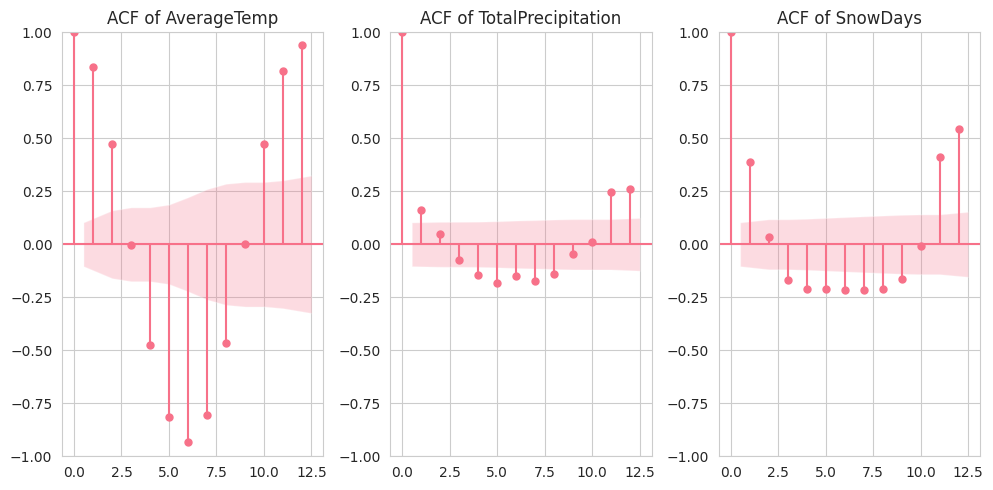

In [ ]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("husl")

tar_data = ["平均気温(℃)", "降水量の合計(mm)", "雪日数(日)"]
titles = ['AverageTemp', 'TotalPrecipitation', 'SnowDays']

fig, axes = plt.subplots(nrows=1, ncols=len(tar_data), figsize=(10, 5))

for i, (tar, title) in enumerate(zip(tar_data, titles)):
    sm.graphics.tsa.plot_acf(df[tar], lags=12, ax=axes[i])
    axes[i].set_title(f'ACF of {title}')

plt.tight_layout()
plt.show()


### トレンド/季節性/残差分解


**観測期間:1993/1～2022/12**
各項目のトレンド分析実施し、東京の気候が温暖化の影響を受けていることを示唆しています。
1.   **平均気温(℃)**:2014年(250~)が不自然に下がり傾向だった。⇒原因後述
2.   **最高気温(℃)**:上昇傾向のため、温暖化の兆候
3.   **最低気温(℃)**:低下傾向で、地域の気候変動、都市化、または他の要因による可能性ある
4.   **降水量の合計(mm)**:上昇傾向のため、温暖化により、水の蒸発と降水量が増加する傾向
5.   **日降水量の最大(mm)**:同上
6.   **雪日数(日)**:低下傾向で、雪日数の減少しているため、温暖化が冬の気温を上昇させ、雪が降る機会の減少が示している

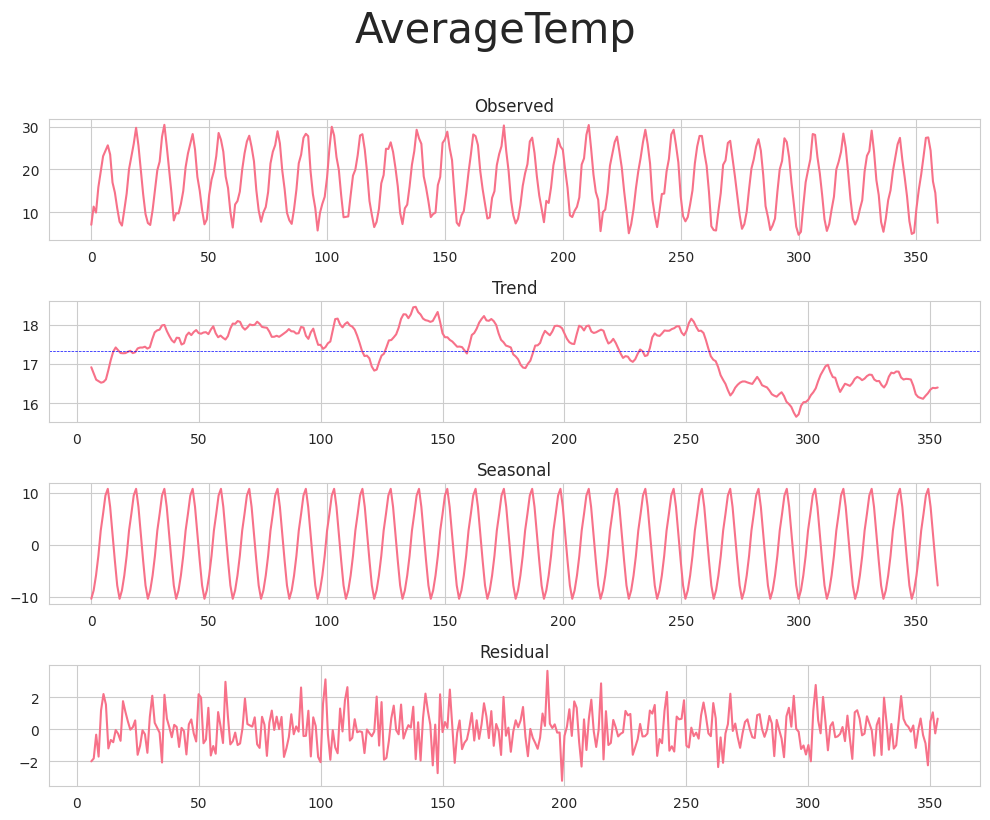

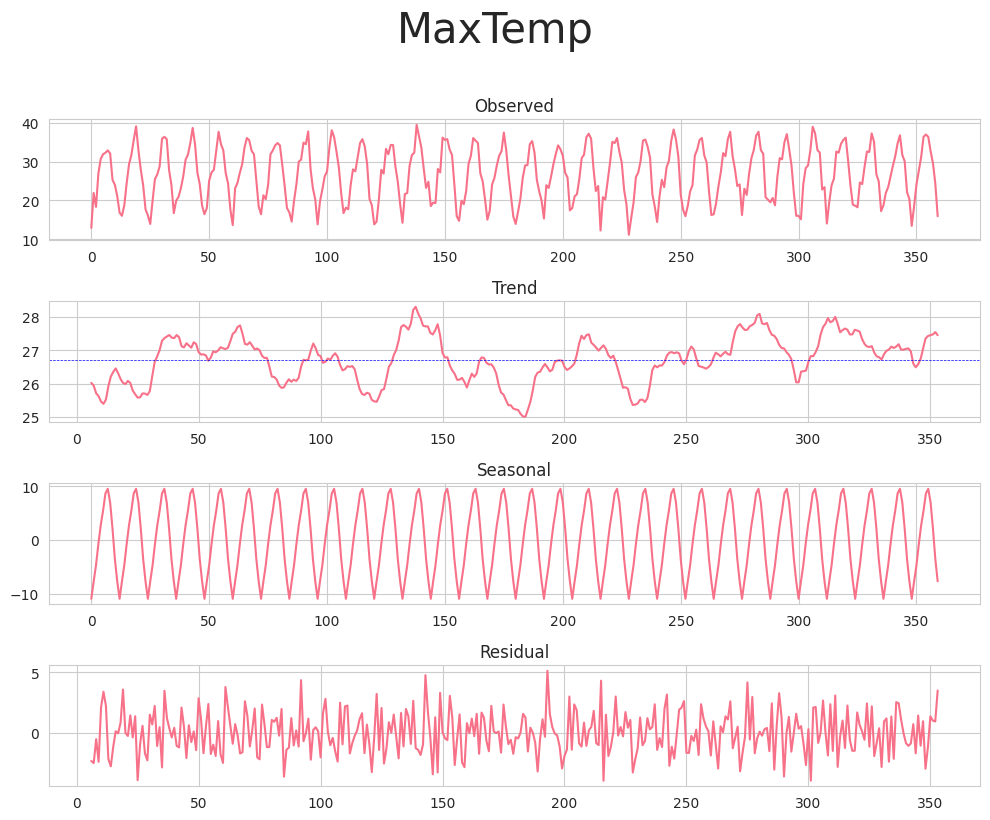

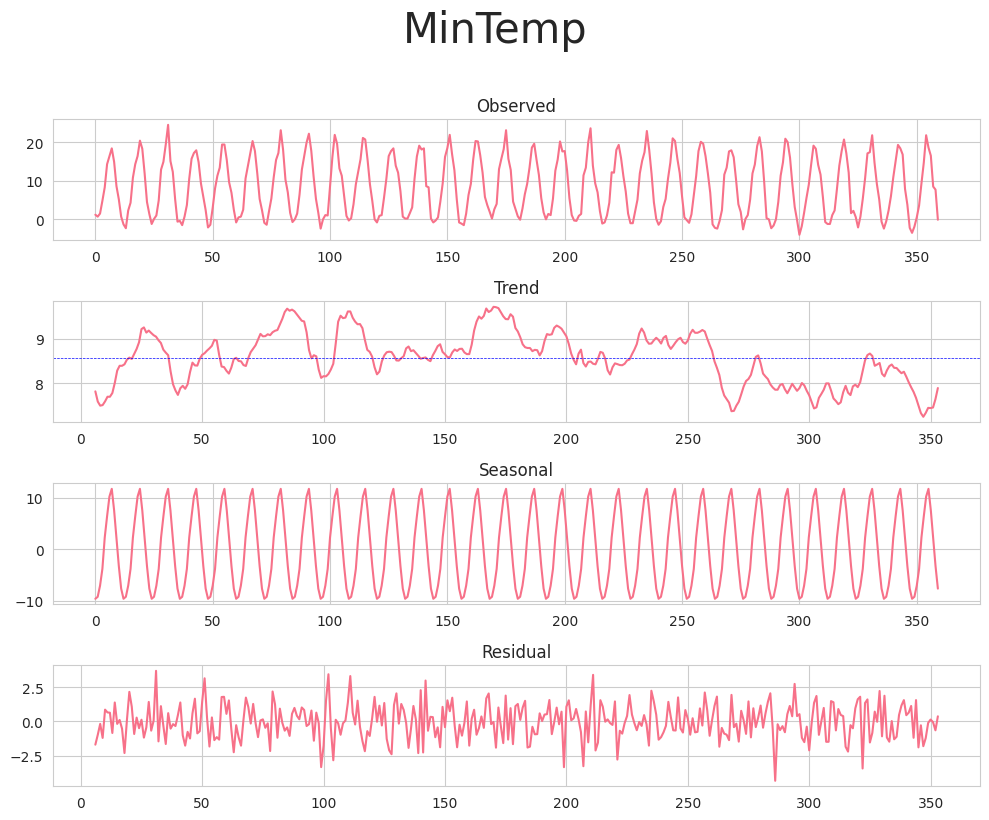

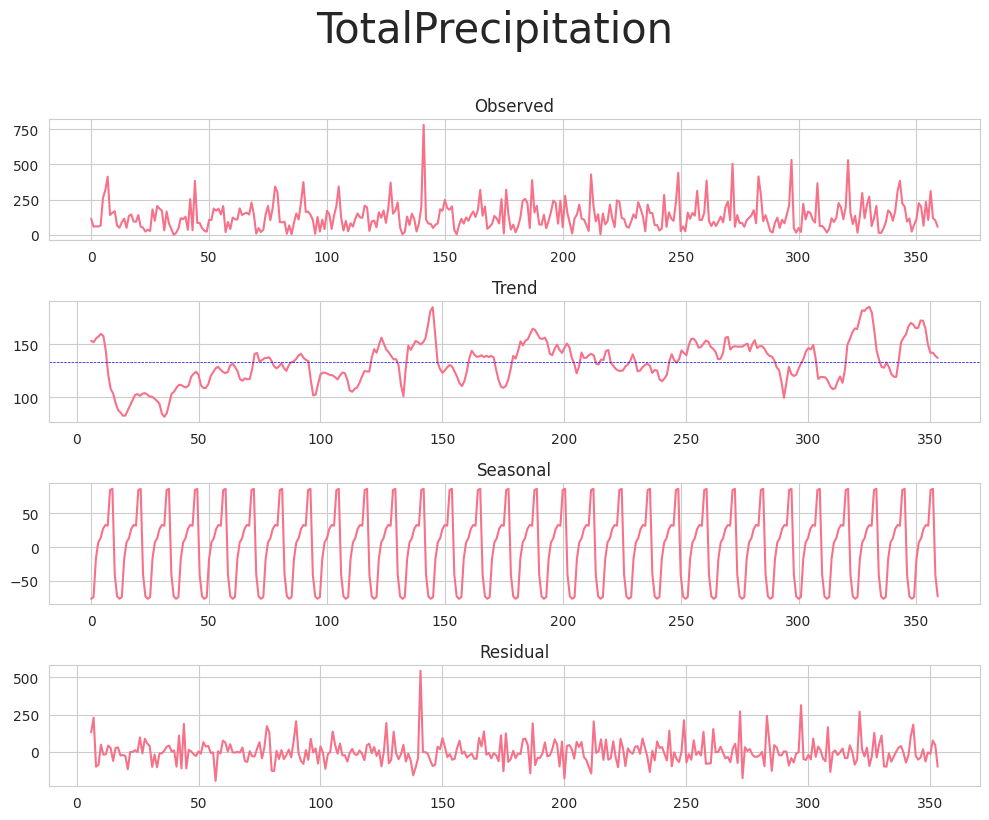

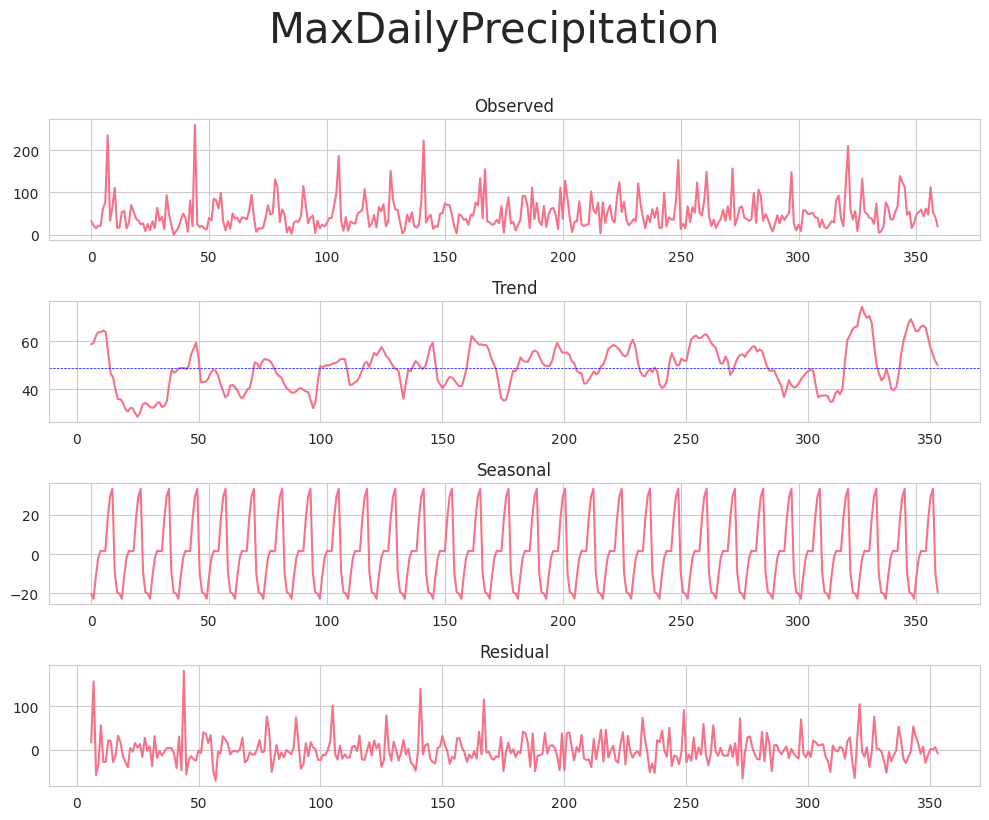

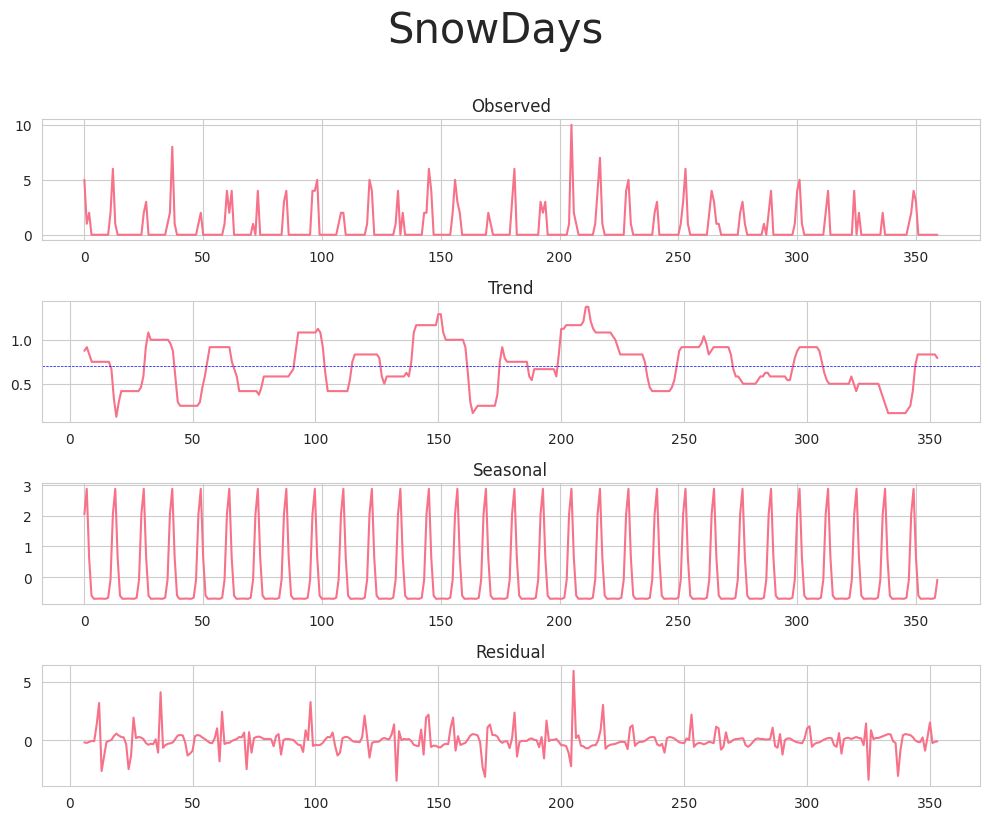

In [ ]:
# グラフ描画用の関数を定義
def plot_seasonal_decompose(ax, series, title, mean_value=None):
    ax.plot(series)
    ax.set_title(title)
    if mean_value is not None:  # mean_valueが提供されている場合、中央線を描画
        ax.axhline(y=mean_value, color='blue', linestyle='--', linewidth=0.5)

# タイトルのリスト
titles = [
    'AverageTemp', 'MaxTemp', 'MinTemp', 'TotalPrecipitation',
    'MaxDailyPrecipitation', 'SnowDays'
]

# データフレームの各列に対してseasonal_decomposeを適用し、結果をプロット
for col, title in zip(df.columns, titles):
    result = sm.tsa.seasonal_decompose(df[col].values, period=12)

    # 4つのsubplotを持つfigureを作成
    fig, axes = plt.subplots(4, 1, figsize=(10, 8))

    # 各コンポーネントをプロット
    plot_seasonal_decompose(axes[0], result.observed, 'Observed')
    plot_seasonal_decompose(axes[1], result.trend, 'Trend', mean_value=df[col].mean())
    plot_seasonal_decompose(axes[2], result.seasonal, 'Seasonal')
    plot_seasonal_decompose(axes[3], result.resid, 'Residual')

    # 全体のタイトルを設定
    plt.suptitle(title, y=1.02, fontsize=30)
    plt.tight_layout()
    plt.show()


### 平均気温調査



- 欠損データ期間は1993/1~2014/9で、period<250のため、最高気温と最低気温の平均が平均気温を上げていることが不自然な原因と考えられる。
- 一旦欠損していないデータを用いて再度分析する
- 結果は上昇傾向のため、温暖化の兆候があると考えられる

In [ ]:
# 欠損データ期間確認：1993/1~2014/9
raw_data[raw_data['平均気温(℃)']=='///']

,Unnamed: 0,平均気温(℃),最高気温(℃),最低気温(℃),降水量の合計(mm),日降水量の最大(mm),雪日数(日)
1,1993年1月,///,12.9,1.2,115.0,32.5,5.0
2,1993年2月,///,21.9,0.7,57.0,22.0,1.0
3,1993年3月,///,18.3,1.5,60.5,15.5,2.0
4,1993年4月,///,26.9,4.8,58.0,21.5,0.0
5,1993年5月,///,30.7,8.3,65.5,21.0,0.0
...,...,...,...,...,...,...,...
259,2014年7月,///,35.6,20.1,105.5,53.0,0.0
260,2014年8月,///,36.1,19.6,105.0,45.0,0.0
261,2014年9月,///,31.6,16.4,155.5,81.0,0.0
262,2014年10月,///,29.8,11.9,384.5,148.5,0.0


In [ ]:
(2014-1993)*12-1

251

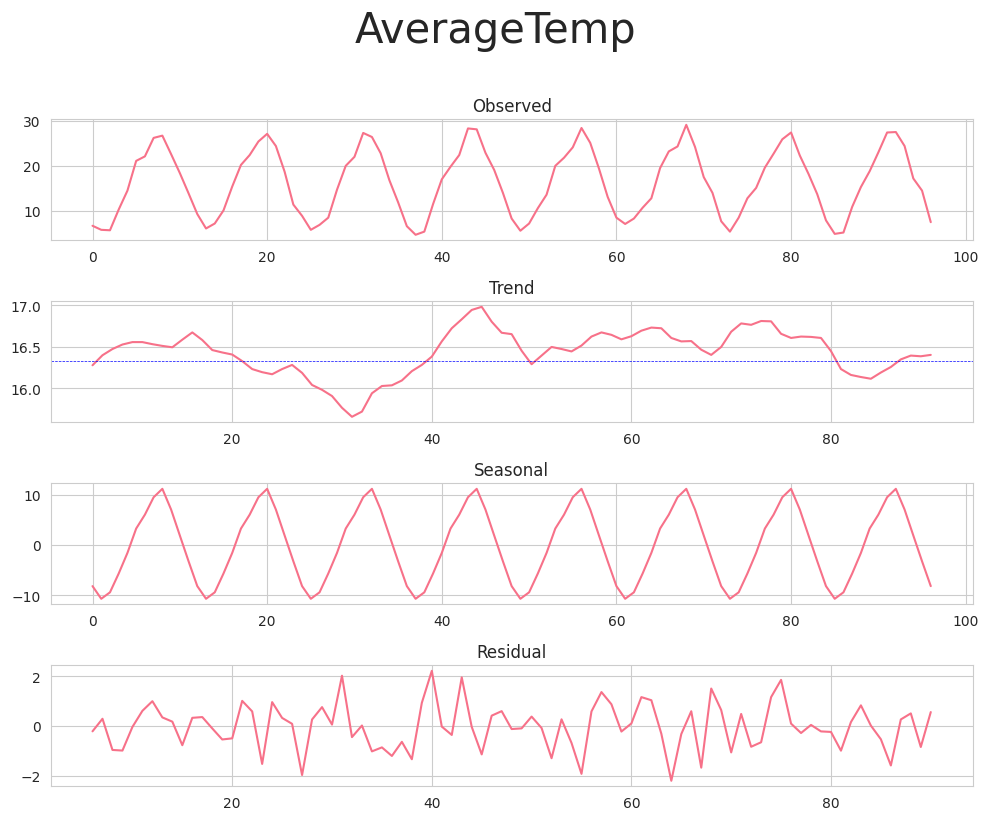

In [ ]:
# 2014/11以降欠損されていないデータに絞る
AverageTemp=df[df.index > '2014-11-01']['平均気温(℃)']

result = sm.tsa.seasonal_decompose(AverageTemp.values, period=12)
title='AverageTemp'
# col='平均気温(℃)'
# 4つのsubplotを持つfigureを作成
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# 各コンポーネントをプロット
plot_seasonal_decompose(axes[0], result.observed, 'Observed')
plot_seasonal_decompose(axes[1], result.trend, 'Trend', mean_value=AverageTemp.mean())
plot_seasonal_decompose(axes[2], result.seasonal, 'Seasonal')
plot_seasonal_decompose(axes[3], result.resid, 'Residual')

# 全体のタイトルを設定
plt.suptitle(title, y=1.02, fontsize=30)
plt.tight_layout()
plt.show()

## 2030年と2050年予測

### データ分割
- 訓練データ：80%
- テストデータ：20%

In [ ]:
# 平均気温以外
train_size = int(len(df) * TRAIN_SIZE)
train_data = df.iloc[:train_size,1:]
test_data = df.iloc[train_size:,1:]
print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

# 平均気温
at_train_size = int(len(AverageTemp) * TRAIN_SIZE)
at_train_data = AverageTemp[:at_train_size]
at_test_data = AverageTemp[at_train_size:]
print(f'AT Training data length: {len(at_train_data)}')
print(f'AT Test data length: {len(at_test_data)}')

Training data shape: (288, 5)
Test data shape: (72, 5)
AT Training data length: 77
AT Test data length: 20


### モデル作成

#### モデル定義

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.tseries.offsets import DateOffset

def predict_model(train_data,test_data,start,end,lags,col,predict_flg):
    # モデルの定義
    model_ar = AutoReg(train_data, lags=lags)

    # モデルの学習
    result_ar = model_ar.fit()

    # 予測
    prediction_ar = result_ar.predict(start=start, end=end)

    # AR　月平均
    if predict_flg== True:
        plt.plot(test_data,label="actual")
    plt.plot(prediction_ar,label = "predict")

    plt.title("predict VS actual", fontsize=20)
    plt.ylabel(f'{col}', fontsize=20)

    plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
    plt.subplots_adjust(left = 0.1, right = 0.8)

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    return prediction_ar

#### 平均気温
- 予測と実績は概ねあっているが、2022/1-3,2022/6-9のがずれている。
- 2030年は2022年と比べて全体的+1.0度となり、春・夏の平均温度下がり、秋・冬の平均温度は上がっている
- 2050年は2022年と比べて全体的+2.0度となり、夏・秋の平均温度下がり、冬・春の平均温度は上がっている

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


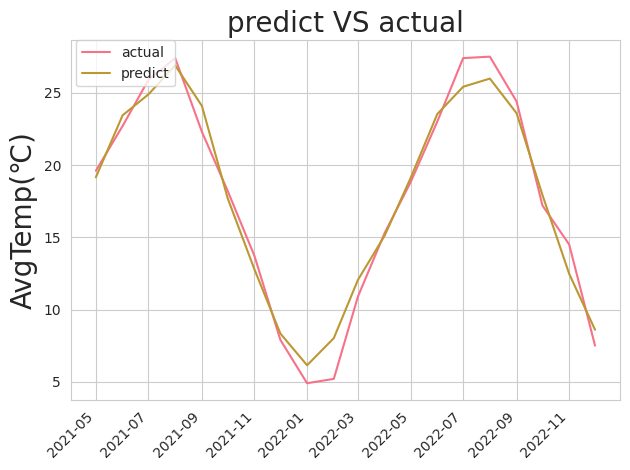

In [ ]:
# 平均気温
result = predict_model(train_data=at_train_data,
              test_data=at_test_data,
              start=len(at_train_data),
              end=len(AverageTemp)-1,
              lags=12,
              col='AvgTemp(℃)',
              predict_flg=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


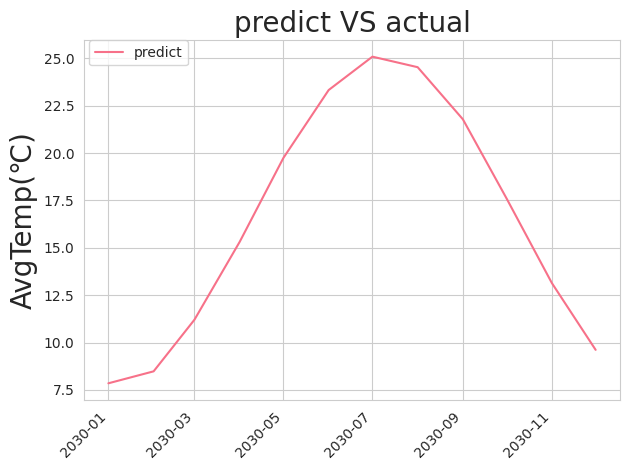

In [ ]:
result=predict_model(train_data=at_train_data,
              test_data=at_test_data,
              start=15*12+1,
              end=16*12,
              lags=12,
              col='AvgTemp(℃)',
              predict_flg=False)


In [ ]:
tar=AverageTemp[-12:]
print("###########平均気温変化：2030年度－2022年度###############")
changes=0.0
for i in range(12):
    change=round(result[i]-tar[i],1)
    changes+=change
    print(f'{i+1}月:{change}')
print(f'#######TOTAL：{changes}')

###########平均気温変化：2030年度－2022年度###############
1月:3.0
2月:3.3
3月:0.3
4月:0.0
5月:1.0
6月:0.3
7月:-2.3
8月:-3.0
9月:-2.6
10月:0.4
11月:-1.4
12月:2.1
#######TOTAL：1.0999999999999996


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


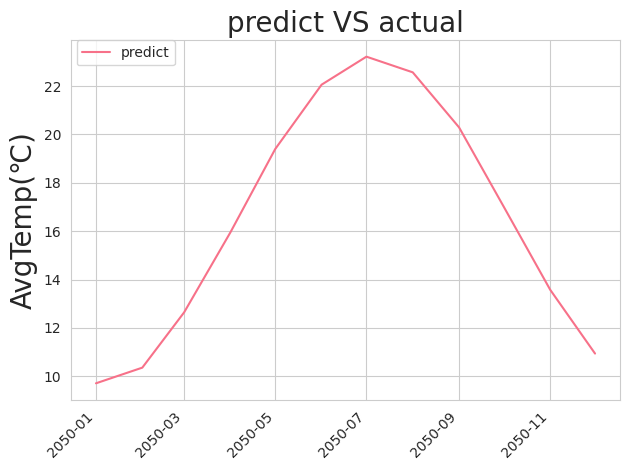

In [ ]:
result=predict_model(train_data=at_train_data,
              test_data=at_test_data,
              start=35*12+1,
              end=36*12,
              lags=12,
              col='AvgTemp(℃)',
              predict_flg=False)

In [ ]:
tar=AverageTemp[-12:]
print("###########平均気温変化：2050年度－2022年度###############")
changes=0.0
for i in range(12):
    change=round(result[i]-tar[i],1)
    changes+=change
    print(f'{i+1}月:{change}')
print(f'#######TOTAL：{changes}')

###########平均気温変化：2050年度－2022年度###############
1月:4.8
2月:5.2
3月:1.7
4月:0.7
5月:0.6
6月:-0.9
7月:-4.2
8月:-4.9
9月:-4.1
10月:-0.2
11月:-0.9
12月:3.4
#######TOTAL：1.1999999999999975


#### 降水量の合計(mm)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


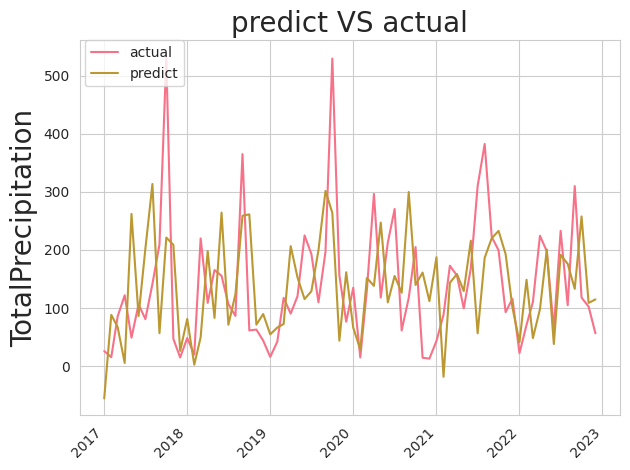

2017-01-01    -55.462442
2017-02-01     88.329753
2017-03-01     67.502777
2017-04-01      5.563451
2017-05-01    262.096060
                 ...    
2022-08-01    176.118119
2022-09-01    133.041755
2022-10-01    257.697738
2022-11-01    108.937886
2022-12-01    114.958607
Freq: MS, Length: 72, dtype: float64

In [ ]:
predict_model(train_data=train_data['降水量の合計(mm)'],
              test_data=test_data['降水量の合計(mm)'],
              start=len(train_data),
              end=len(df)-1,
              lags=365,
              col='TotalPrecipitation',
              predict_flg=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


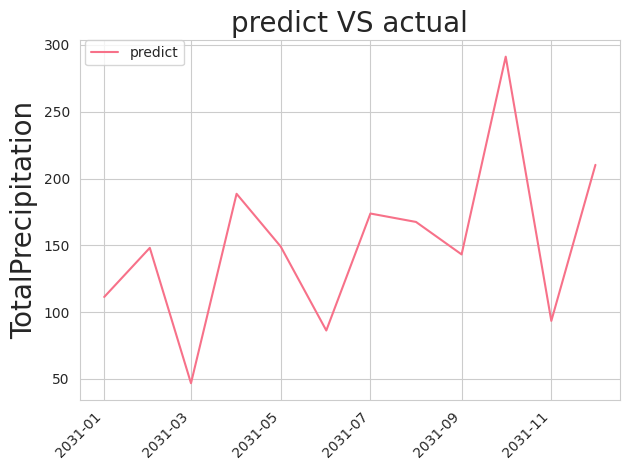

In [ ]:
result=predict_model(train_data=train_data['降水量の合計(mm)'],
              test_data=test_data['降水量の合計(mm)'],
              start=38*12,
              end=39*12-1,
              lags=100,
              col='TotalPrecipitation',
              predict_flg=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


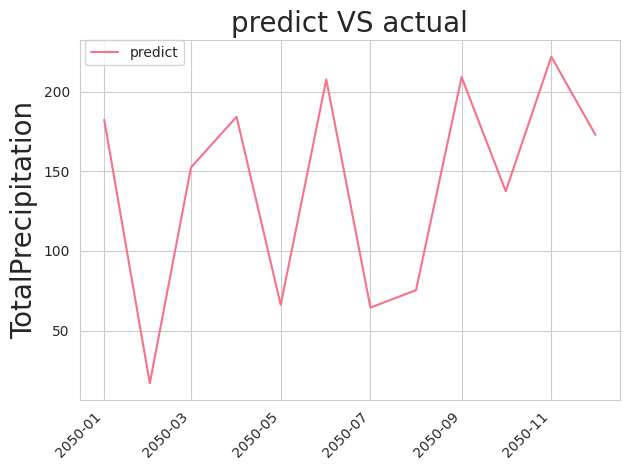

In [ ]:
result=predict_model(train_data=train_data['降水量の合計(mm)'],
              test_data=test_data['降水量の合計(mm)'],
              start=57*12,
              end=58*12-1,
              lags=100,
              col='TotalPrecipitation',
              predict_flg=False)

#### 雪日数(日)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


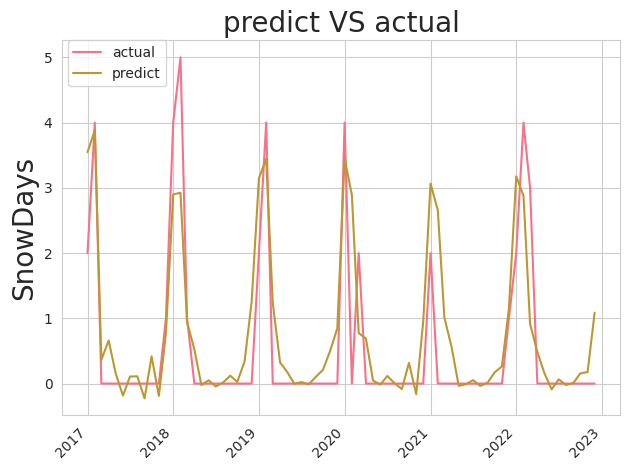

In [ ]:
result = predict_model(train_data=train_data['雪日数(日)'],
              test_data=test_data['雪日数(日)'],
              start=len(train_data),
              end=len(df)-1,
              lags=60,
              col='SnowDays',
              predict_flg=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


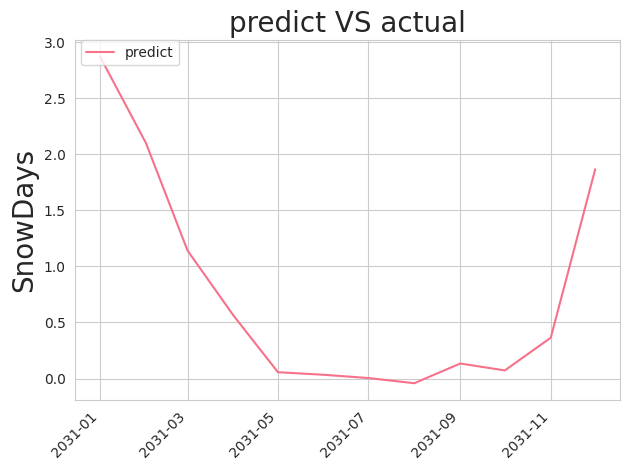

In [ ]:
result=predict_model(train_data=train_data['雪日数(日)'],
              test_data=test_data['雪日数(日)'],
              start=38*12,
              end=39*12-1,
              lags=60,
              col='SnowDays',
              predict_flg=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


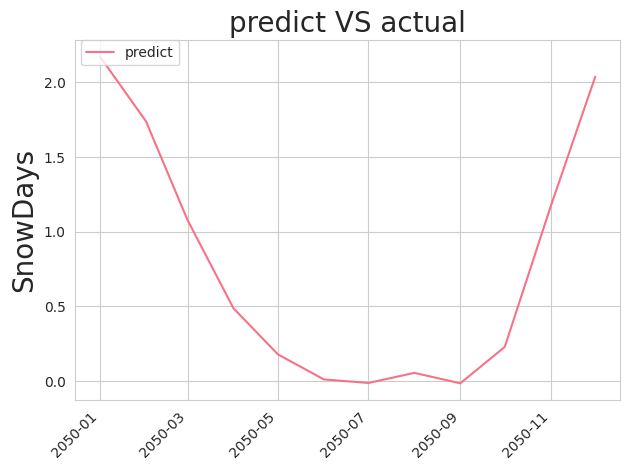

In [ ]:
result=predict_model(train_data=train_data['雪日数(日)'],
              test_data=test_data['雪日数(日)'],
              start=57*12,
              end=58*12-1,
              lags=60,
              col='SnowDays',
              predict_flg=False)